In [1]:
import numpy as np
import pandas as pd
import os

In [5]:
# define a class including all parameter
class Para:
    method = 'SVM'
    month_in_sample = range(1,62 + 1) #return in-sample months
    month_test = range(63,124 + 1) #return test months
    percent_select = [0.3,0.3] # 30% positive samples, 30% NEGATIVE SAMPLES
    percent_cv = 0.1 #10% cross validation samples
    path_data = os.getcwd() + '\\csv\\'
    path_results = os.getcwd() + '\\results_demo\\'
    seed = 2019
    svm_kernel = 'linear'
    svm_c = 0.01
    #n_stock=100
para = Para()

In [6]:
def label_data(data):
    data['return_bin'] = np.nan
    data = data.sort_values(by = 'return',ascending = False)
    # decide how much stocks will be selected
    n_stock_select = np.multiply(para.percent_select,data.shape[0])
    n_stock_select = np.around(n_stock_select).astype(int)
    data.iloc[0:n_stock_select[0],-1] = 1
    data.iloc[-n_stock_select[1]:,-1] = 0
    data = data.dropna(axis=0)
    return data


In [8]:
#generate in-sample data
for i_month in para.month_in_sample:
    file_name = para.path_data + str(i_month) + '.csv'
    data_curr_month = pd.read_csv(file_name, header=0)
    para.n_stock = data_curr_month.shape[0]

    data_curr_month = data_curr_month.dropna(axis=0)
    # label data
    data_curr_month = label_data(data_curr_month)
    if i_month == para.month_in_sample[0]: 
        data_in_sample = data_curr_month
    else:
        data_in_sample = data_in_sample.append(data_curr_month)


In [9]:
# generate training and cv sets
X_in_sample = data_in_sample.loc[:, 'beta':'MFI14']
y_in_sample = data_in_sample.loc[:, 'return_bin']
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X_in_sample, y_in_sample, test_size=para.percent_cv, random_state=para.seed)
# PCA
from sklearn import decomposition
pca = decomposition.PCA(n_components=0.95)
pca.fit(X_train)
X_train = pca.transform(X_train) 
X_cv = pca.transform(X_cv)

In [10]:
# preprocessing
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_cv = scaler.transform(X_cv)

In [11]:
# set model
if para.method == 'SVM':
    from sklearn import svm
    model = svm.SVC(kernel=para.svm_kernel, C=para.svm_c)

In [12]:
model

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [13]:
pd.DataFrame(X_train).tail()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
63160,-0.761618,0.903000,-1.372777,0.446470,-0.660306,0.165650,1.431948,-1.209054,0.289839,1.010978,...,-0.815243,-1.546771,1.134858,0.561157,0.116055,-0.741031,-1.092319,-1.248569,-0.021005,1.867282
63161,1.198555,0.009350,0.258896,0.138273,0.195825,1.290667,-1.689487,0.157464,0.737597,-1.091946,...,0.329264,-0.784252,-1.603605,0.880039,-0.324173,-1.788841,-0.802140,-0.395198,0.313553,0.164142
63162,0.319523,0.281559,-0.670156,-0.548483,-1.099273,0.998638,-0.332319,0.493475,-0.321238,1.319294,...,0.009572,-0.254984,0.300632,0.839267,-0.260203,-0.059972,-0.420644,-0.067476,0.305804,-0.025650
63163,1.379614,-0.398023,-0.489692,-0.714350,0.420999,-1.833134,0.468929,0.612118,-0.046011,-1.633370,...,-0.013343,-0.324225,-1.633781,0.029009,0.890089,-0.281499,-0.223344,0.303193,0.980554,1.382236
63164,-0.789582,-0.094099,-0.665696,-0.825249,1.416677,-0.720642,-0.841495,0.330707,-0.601267,0.205831,...,0.294027,-0.520682,-0.545138,1.139243,-0.096900,-0.752697,0.881194,-0.744197,-0.180976,0.254868


In [14]:
if para.method == 'SVM':
    model.fit(X_train,y_train)
    y_pred_train = model.predict(X_train) 
    y_score_train = model.decision_function(X_train)
    y_pred_cv = model.predict(X_cv) 
    y_score_cv = model.decision_function(X_cv)

In [15]:
# initialize
y_true_test = pd.DataFrame([np.nan] * np.ones((para.n_stock,para.month_test[-1])))
y_pred_test = pd.DataFrame([np.nan] * np.ones((para.n_stock,para.month_test[-1])))
y_score_test = pd.DataFrame([np.nan] * np.ones((para.n_stock,para.month_test[-1])))

In [16]:
# loop  for months
for i_month in para.month_test:
    file_name = para.path_data + str(i_month) + '.csv' 
    data_curr_month = pd.read_csv(file_name, header = 0)
    data_curr_month = data_curr_month.dropna(axis=0) #-- remove nan
    X_curr_month = data_curr_month.loc[:,'beta':'MFI14'] #-- generate X
    X_curr_month = pca.transform(X_curr_month) #-- pca
    
    # predict
    if para.method== 'SVM':
        y_pred_curr_month = model.predict(X_curr_month) 
        y_score_curr_month = model.decision_function(X_curr_month)
    
    #save true and predicted return
    y_true_test.iloc[data_curr_month.index,i_month-1]=data_curr_month['return'][data_curr_month.index]
    y_pred_test.iloc[data_curr_month.index,i_month-1]=y_pred_curr_month
    y_score_test.iloc[data_curr_month.index,i_month-1]=y_score_curr_month

In [17]:
i_month

124

In [18]:
# evaluate the training and cv sets
from sklearn import metrics
print('training set, accuracy = %.2f'%metrics.accuracy_score(y_train, y_pred_train)) 
print('training set, AUC = %.2f'%metrics.roc_auc_score(y_train, y_score_train))
print('cv set, accuracy = %.2f'%metrics.accuracy_score(y_cv, y_pred_cv)) 
print('cv set, AUC = %.2f'%metrics.roc_auc_score(y_cv, y_score_cv))

# evaluate the testing set by months
for i_month in para.month_test:
    y_true_curr_month = pd.DataFrame({'return':y_true_test.iloc[:,i_month-1]}) 
    y_pred_curr_month = y_pred_test.iloc[:,i_month-1]
    y_score_curr_month = y_score_test.iloc[:,i_month-1]
    y_true_curr_month = y_true_curr_month.dropna(axis=0)
    y_curr_month = label_data(y_true_curr_month)['return_bin']
y_pred_curr_month = y_pred_curr_month[y_curr_month.index] 
y_score_curr_month = y_score_curr_month[y_curr_month.index]
print('test set, month %d, accuracy = %.2f'%(i_month, metrics.accuracy_score(y_curr_month, y_pred_curr_month)))
print('test set, month %d, AUC = %.2f'%(i_month, metrics.roc_auc_score(y_curr_month, y_score_curr_month)))


training set, accuracy = 0.55
training set, AUC = 0.57
cv set, accuracy = 0.55
cv set, AUC = 0.57
test set, month 124, accuracy = 0.52
test set, month 124, AUC = 0.54


In [19]:
# initialize a strategy
para.n_stock_select = 100
strategy = pd.DataFrame({'return':[0] * para.month_test[-1],'value':[1] * para.month_test[-1]})
for i_month in para.month_test:
    y_true_curr_month = y_true_test.iloc[:,i_month-1] 
    y_score_curr_month = y_score_test.iloc[:,i_month-1]
    y_score_curr_month = y_score_curr_month.sort_values(ascending=False)
    index_select = y_score_curr_month[0:para.n_stock_select].index
    strategy.loc[i_month-1,'return'] = np.mean(y_true_curr_month[index_select])
    strategy['value'] = (strategy['return']+1).cumprod()
    

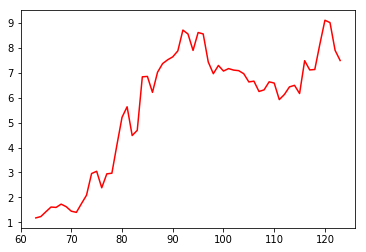

In [21]:
# plot the value
import matplotlib.pyplot as plt
plt.plot(para.month_test,strategy.loc[para.month_test,'value'],'r-') 
plt.show()


In [22]:
# evaluation
ann_excess_return = np.mean(strategy.loc[para.month_test,'return']) * 12
ann_excess_vol = np.std(strategy.loc[para.month_test,'return']) * np.sqrt(12)
info_ratio = ann_excess_return/ann_excess_vol
print('annual excess return = %.2f'%ann_excess_return) 
print('annual excess volatility = %.2f'%ann_excess_vol) 
print('information ratio = %.2f'%info_ratio)


annual excess return = 0.49
annual excess volatility = 0.45
information ratio = 1.07


In [23]:
# save resulrs
import os
if not os.path.exists(para.path_results): 
    os.makedirs(para.path_results)
    filename = para.path_results + 'dataTestYhat.csv'
    y_score_test.to_csv(filename,header=0,index=False)
